# Research Project - Fine-grained sentiment analysis: SST-5

### **Student:** Ariel Ricardo Ramos Vela



In [ ]:
#Import required libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.optim import AdamW
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
from sklearn.ensemble import RandomForestClassifier


import gensim
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sns
import numpy as np




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#Load training, validation and testing datasets
train_dataset = pd.read_csv('./train.txt', sep="\t", header=None, names=["label", "data"])
validation_dataset = pd.read_csv('./dev.txt', sep="\t", header=None, names=["label", "data"])
test_dataset = pd.read_csv('./test.txt', sep="\t", header=None, names=["label", "data"])

In [ ]:
#Make labels start from 0 
train_dataset['label'] = train_dataset['label'] -1
validation_dataset['label'] = validation_dataset['label'] -1
test_dataset['label'] = test_dataset['label'] -1

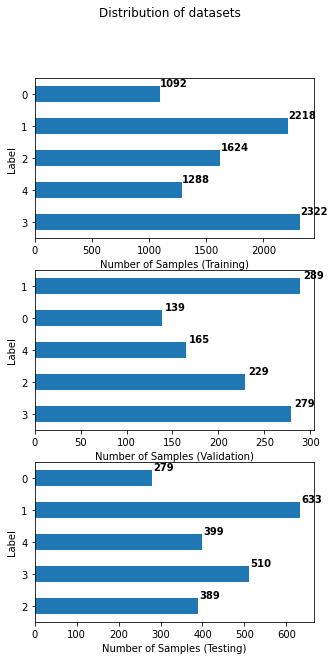

In [ ]:
#Explore distribution of datasets

fig, ax = plt.subplots(3, figsize=(5,10))
fig.suptitle('Distribution of datasets')


#Training data

ax[0] = train_dataset['label'].value_counts(sort=False).plot(kind='barh', ax=ax[0])
ax[0].set_xlabel('Number of Samples (Training)')
ax[0].set_ylabel('Label')

for i, v in enumerate(train_dataset['label'].value_counts(sort=False)):
    ax[0].text(v + 3, i + .25, str(v), fontweight='bold')

# #Validation data
ax[1] = validation_dataset['label'].value_counts(sort=False).plot(kind='barh', ax=ax[1])
ax[1].set_xlabel('Number of Samples (Validation)')
ax[1].set_ylabel('Label')

for i, v in enumerate(validation_dataset['label'].value_counts(sort=False)):
    ax[1].text(v + 3, i + .25, str(v), fontweight='bold')

# #Testing data
ax[2] = test_dataset['label'].value_counts(sort=False).plot(kind='barh', ax=ax[2])
ax[2].set_xlabel('Number of Samples (Testing)')
ax[2].set_ylabel('Label')

for i, v in enumerate(test_dataset['label'].value_counts(sort=False)):
    ax[2].text(v + 3, i + .25, str(v), fontweight='bold')

In [ ]:
#Oversampling majority class (3) in training dataset
c0 = train_dataset[train_dataset['label'] == 0]
c1 = train_dataset[train_dataset['label'] == 1]
c2 = train_dataset[train_dataset['label'] == 2]
c3 = train_dataset[train_dataset['label'] == 3]
c4 = train_dataset[train_dataset['label'] == 4]

max_count = train_dataset.label.value_counts().max()

over_c0 = c0.sample(max_count, replace='True')
over_c1 = c1.sample(max_count, replace='True')
over_c2 = c2.sample(max_count, replace='True')
over_c4 = c4.sample(max_count, replace='True')

oversampled_train_dataset = pd.concat([over_c0,over_c1, over_c2, c3, over_c4], axis=0)

#Undersampling to minority class (0) in training dataset
min_count = train_dataset.label.value_counts().min()
under_c1 = c1.sample(min_count)
under_c2 = c2.sample(min_count)
under_c3 = c3.sample(min_count)
under_c4 = c4.sample(min_count)

undersampled_train_dataset = pd.concat([c0,under_c1, under_c2, under_c3, under_c4], axis=0)

print('Oversampled dataset: \n', oversampled_train_dataset.label.value_counts())

print('Undersampled dataset: \n', undersampled_train_dataset.label.value_counts())

Oversampled dataset: 
 0    2322
1    2322
2    2322
3    2322
4    2322
Name: label, dtype: int64
Undersampled dataset: 
 0    1092
1    1092
2    1092
3    1092
4    1092
Name: label, dtype: int64


In [ ]:
corpus_train = oversampled_train_dataset["data"]
# corpus_train = undersampled_train_dataset["data"]

corpus_validation = validation_dataset["data"]
corpus_test = test_dataset["data"]

#Preprocessing
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


def preprocess(string):

    #Remove punctuation and lower case
    # print(string)
    string = re.sub(r'[^\w\s]', '', string.lower())
    lst_words = string.split()

    #Remove stop words
    non_stop_words = [word for word in lst_words if word not in stop_words]
    if len(non_stop_words) < 1:
        non_stop_words = lst_words

    #Stemming / Lemmatizing
    # lst_words = [stemmer.stem(word) for word in non_stop_words]
    lst_words = [lemmatizer.lemmatize(word) for word in non_stop_words]
    
    # print(lst_words)
    return lst_words



def get_grams(corpus):

    lst_corpus = []

    for string in corpus:

        lst_words = preprocess(string)

        lst_grams = [" ".join(lst_words[i:i+1]) 
                for i in range(0, len(lst_words), 1)]
    
        lst_corpus.append(lst_grams)
    
    return lst_corpus


#create list of lists of unigrams
lst_corpus = []

lst_corpus_train = get_grams(corpus_train)
lst_corpus_val = get_grams(corpus_validation)
lst_corpus_test = get_grams(corpus_test)

lst_corpus.extend(lst_corpus_train)
lst_corpus.extend(lst_corpus_val)
lst_corpus.extend(lst_corpus_test)


In [ ]:
print(len(corpus_train) + len(corpus_validation) + len(corpus_test))
print(len(lst_corpus))

14921
14921


In [ ]:
# fit w2v
w2v_model = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1, iter=30)

In [ ]:
#Try model
w2v_model.wv.__getitem__("rock").shape
# w2v_model.wv.index2word

(300,)

In [ ]:
#Now get a representation of a phrase by averaging vectors

def prepare_X(corpus):
    X = np.zeros((len(corpus), 300))

    for i, string in enumerate(corpus):
        # lst_words = string.split()
        lst_words = preprocess(string)
        if len(lst_words) == 0:
            print(string)
            print(lst_words)
            break
        for j, w in enumerate(lst_words):
            # print(j, w)
            if j == 0:
                vector = w2v_model.wv.__getitem__(w)
                # print(vector)
            else:
                vector = np.add(vector, w2v_model.wv.__getitem__(w))
                # print(vector.shape)
        
        vector = np.divide(vector, len(lst_words))
        X[i] = vector
    return X

In [ ]:
X_train = prepare_X(corpus_train)
# y_train = undersampled_train_dataset['label']
y_train = oversampled_train_dataset['label']




In [ ]:
#Validation step
X_validation = prepare_X(corpus_validation)
y_validation = validation_dataset['label']


In [ ]:
#Hypertuning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]



In [ ]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [50, 55, 61, 66, 72, 77, 83, 88, 94, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [ ]:
clf = RandomForestClassifier(random_state=0)

rf_Grid = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 10, verbose=1, n_jobs = 1)
rf_Grid.fit(X_train, y_train)

Fitting 10 folds for each of 320 candidates, totalling 3200 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=0), n_jobs=1,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 55, 61, 66, 72, 77, 83, 88, 94,
                                          100]},
             verbose=1)

In [ ]:
rf_Grid.best_params_

{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [ ]:
#Calculate validation accuracy
val_accuracy = rf_Grid.score(X_validation,y_validation)
print('Validation accuracy: ', val_accuracy)

Validation accuracy:  0.32879200726612173


In [ ]:
#Testing with best hyperparameters
X_test = prepare_X(corpus_test)
y_test = test_dataset['label']

clf = RandomForestClassifier(random_state=0, bootstrap=True, max_depth=4, max_features='auto', min_samples_leaf=2, min_samples_split=2, n_estimators=100)
clf.fit(X_train, y_train)

testing_accuracy = clf.score(X_test, y_test)
print('Testing accuracy: ', testing_accuracy)

y_pred = clf.predict(X_test)


Testing accuracy:  0.31402714932126696


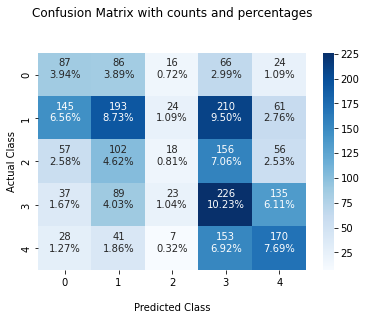

In [ ]:
#Compute confusion matrix and plot it
cf_matrix = confusion_matrix(y_test, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(5,5)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix with counts and percentages\n\n');
ax.set_xlabel('\nPredicted Class')
ax.set_ylabel('Actual Class');

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.25      0.31      0.27       279
           1       0.38      0.30      0.34       633
           2       0.20      0.05      0.08       389
           3       0.28      0.44      0.34       510
           4       0.38      0.43      0.40       399

    accuracy                           0.31      2210
   macro avg       0.30      0.31      0.29      2210
weighted avg       0.31      0.31      0.30      2210



In [ ]:
#Analyze inputs with some examples
class_2 = np.where(y_test == 2)[0]

#Print some examples to see if any pattern in class 2
for i in class_2[::30]:
    print(corpus_test[i])
    print(lst_corpus_test[i])
    print()


Effective but too-tepid biopic
['effective', 'tootepid', 'biopic']

But you 'll definitely want the T-shirt .
['definitely', 'want', 'tshirt']

If the message seems more facile than the earlier films , the images have such a terrible beauty you may not care .
['message', 'seems', 'facile', 'earlier', 'film', 'image', 'terrible', 'beauty', 'may', 'care']

The warm presence of Zhao Benshan makes the preposterous lying hero into something more than he reasonably should be .
['warm', 'presence', 'zhao', 'benshan', 'make', 'preposterous', 'lying', 'hero', 'something', 'reasonably']

The disarming cornball atmosphere has a way of infecting the entire crowd as the film rolls on .
['disarming', 'cornball', 'atmosphere', 'way', 'infecting', 'entire', 'crowd', 'film', 'roll']

Human Resources was a good , straightforward tale , but Time Out is better .
['human', 'resource', 'good', 'straightforward', 'tale', 'time', 'better']

Both awful and appealing .
['awful', 'appealing']

Both stars manage 